In [1]:
"""QUANT: A Minimalist Interval Method for Time Series Classification."""

import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.interval_based import QUANTTransformer


class QUANTClassifier(BaseClassifier):
    """QUANT interval classifier.

    The classifier computes quantiles over a fixed set of dyadic intervals of
    the input series and three transformations of the input time series. For each set of
    intervals extracted, the window is shifted by half the interval length to extract
    more intervals.

    The feature extraction is performed on the first order differences, second order
    differences, and a Fourier transform of the input series along with the original
    series.

    The transform output is then used to train an extra trees classifier by default.

    Parameters
    ----------
    interval_depth : int, default=6
        The depth to stop extracting intervals at. Starting with the full series, the
        number of intervals extracted is ``2 ** depth`` (starting at 0) for each level.
        The features from all intervals extracted at each level are concatenated
        together for the transform output.
    quantile_divisor : int, default=4
        The divisor to find the number of quantiles to extract from intervals. The
        number of quantiles per interval is
        ``1 + (interval_length - 1) // quantile_divisor``.
    estimator : sklearn estimator, default=None
        The estimator to use for classification. If None, an ExtraTreesClassifier
        with 200 estimators is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None, and the default ExtraTreesClassifier is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    See Also
    --------
    QUANTTransformer

    Notes
    -----
    Original code: https://github.com/angus924/quant

    References
    ----------
    .. [1] Dempster, A., Schmidt, D.F. and Webb, G.I., 2023. QUANT: A Minimalist
        Interval Method for Time Series Classification. arXiv preprint arXiv:2308.00928.

    Examples
    --------
    >>> from aeon.classification.interval_based import QUANTClassifier
    >>> from aeon.testing.data_generation import make_example_3d_numpy
    >>> X, y = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=12,
    ...                              random_state=0)
    >>> clf = QUANTClassifier()  # doctest: +SKIP
    >>> clf.fit(X, y)  # doctest: +SKIP
    QUANTClassifier()
    >>> clf.predict(X)  # doctest: +SKIP
    array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])
    """

    _tags = {
        "capability:multivariate": True,
        "algorithm_type": "interval",
        "python_dependencies": "torch",
    }

    def __init__(
        self,
        interval_depth=6,
        quantile_divisor=4,
        estimator=None,
        class_weight=None,
        random_state=None,
    ):
        self.interval_depth = interval_depth
        self.quantile_divisor = quantile_divisor
        self.estimator = estimator
        self.class_weight = class_weight
        self.random_state = random_state
        super().__init__()

    def _fit(self, X, y):
        """Fit the estimator to training data.

        Parameters
        ----------
        X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
            The training data.
        y : 1D np.ndarray of shape (n_cases)
            The class labels for fitting, indices correspond to instance indices in X

        Returns
        -------
        self :
            Reference to self.
        """
        self._transformer = QUANTTransformer(
            interval_depth=self.interval_depth,
            quantile_divisor=self.quantile_divisor,
        )

        self._estimator = _clone_estimator(
            (
                ExtraTreesClassifier(
                    n_estimators=200,
                    max_features=0.1,
                    criterion="entropy",
                    class_weight=self.class_weight,
                    random_state=self.random_state,
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        X_t = self._transformer.fit_transform(X, y)
        self._estimator.fit(X_t, y)

        return self

    def _predict(self, X):
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.array of shape (n_cases, n_channels, n_timepoints)
            The testing data.

        Returns
        -------
        y : array-like of shape (n_cases)
            Predicted class labels.
        """
        return self._estimator.predict(self._transformer.transform(X))

    def _predict_proba(self, X):
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.array of shape (n_cases, n_channels, n_timepoints)
            The testing data.

        Returns
        -------
        y : array-like of shape (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self._estimator.predict_proba(self._transformer.transform(X))
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self._estimator.predict(self._transformer.transform(X))
            for i in range(0, X.shape[0]):
                dists[i, self._class_dictionary[preds[i]]] = 1
            return dists

In [2]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




### Use this mfcc extraction(from scratch)

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (27692, 99, 13)
Labels array shape: (27692,)


In [4]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [5]:
print(X.shape)

(27692, 13, 99)


In [6]:
print(X_train.shape)

(22153, 13, 99)


In [7]:
clf = QUANTClassifier(random_state=42)

In [8]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

QUANTClassifier(random_state=42)

In [9]:
# Predict on the test set
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.7712583498826503


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.786164289303378
Recall (macro): 0.7723866703016911
F1 Score (macro): 0.7662116359956251


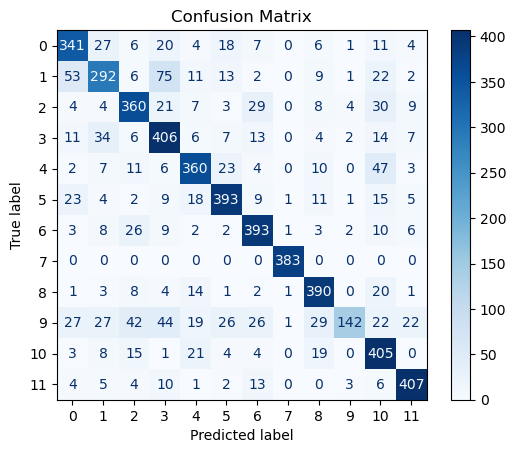

In [11]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [12]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})

Classification Report:
               precision    recall  f1-score   support

        down       0.72      0.77      0.74       445
          go       0.70      0.60      0.65       486
        left       0.74      0.75      0.75       479
          no       0.67      0.80      0.73       510
         off       0.78      0.76      0.77       473
          on       0.80      0.80      0.80       491
       right       0.78      0.85      0.81       465
     silence       0.99      1.00      0.99       383
        stop       0.80      0.88      0.84       445
     unknown       0.91      0.33      0.49       427
          up       0.67      0.84      0.75       480
         yes       0.87      0.89      0.88       455

    accuracy                           0.77      5539
   macro avg       0.79      0.77      0.77      5539
weighted avg       0.78      0.77      0.76      5539

Label mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 

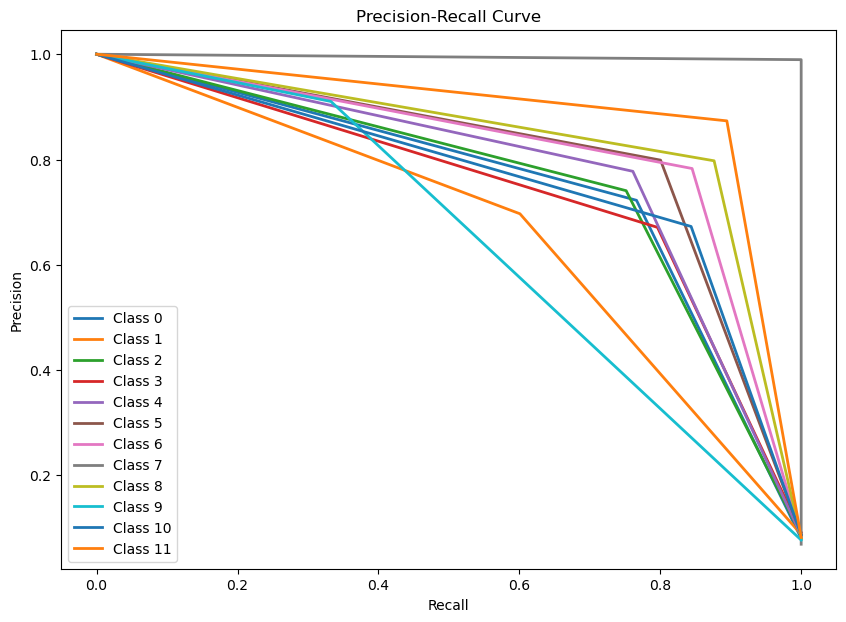

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [14]:
print(X[0][0].shape)

(99,)


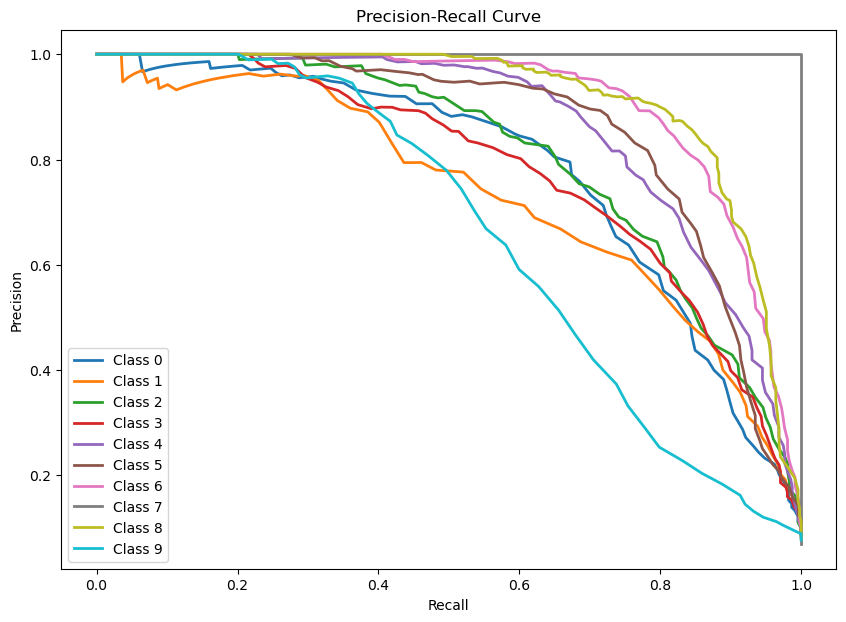

In [15]:
# Get predicted probabilities using the predict_proba() method
y_pred_prob = clf.predict_proba(X_test)

# Binarize the true labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

n_classes = 10

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get precision and recall for each class using the predicted probabilities
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [16]:
print(y_pred_prob)

[[0.045 0.12  0.08  ... 0.04  0.305 0.01 ]
 [0.045 0.085 0.1   ... 0.085 0.035 0.205]
 [0.115 0.13  0.025 ... 0.07  0.03  0.005]
 ...
 [0.04  0.095 0.145 ... 0.06  0.07  0.14 ]
 [0.13  0.125 0.03  ... 0.05  0.005 0.01 ]
 [0.04  0.025 0.005 ... 0.06  0.035 0.035]]


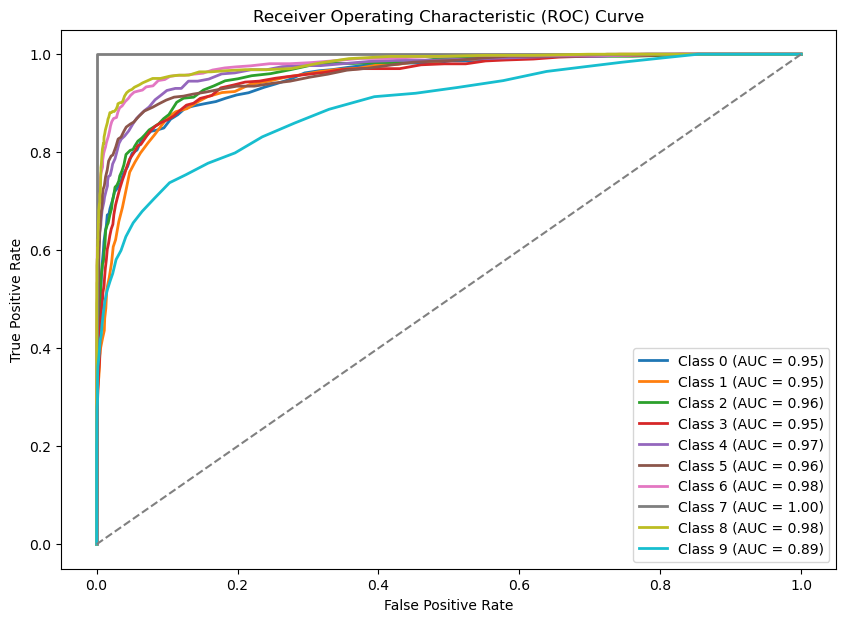

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris




# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get ROC curve metrics for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()


In [18]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       445
           1       0.70      0.60      0.65       486
           2       0.74      0.75      0.75       479
           3       0.67      0.80      0.73       510
           4       0.78      0.76      0.77       473
           5       0.80      0.80      0.80       491
           6       0.78      0.85      0.81       465
           7       0.99      1.00      0.99       383
           8       0.80      0.88      0.84       445
           9       0.91      0.33      0.49       427
          10       0.67      0.84      0.75       480
          11       0.87      0.89      0.88       455

    accuracy                           0.77      5539
   macro avg       0.79      0.77      0.77      5539
weighted avg       0.78      0.77      0.76      5539



In [19]:
99//2

49